In [1]:
%matplotlib widget

In [2]:
from libschrodinger.crank_nicolson_2d import *

In [3]:
import numpy as np

In [4]:
caseName : str = "DynamicStairwell0"

In [5]:
def tunnelCase(position, where, width, potential = 1): 
    return np.where(
            (position.x > where) & (position.x < (where + width)), 
            potential, 
            0, 
        )

In [6]:
def hydrogenAtom(position, potential, bottom = 1): 
    return potential / np.sqrt(
            (position.x / 2) ** 2 \
            + (position.y / 2) ** 2 \
            + bottom ** 2 \
        )

In [7]:
def doubleSlit(position, where, width, slitHeight, gapHeight, potential = 1, math=np): 
    totalY = math.max(position.y)
    return math.where(
            (position.x > where) & (position.x < (where + width)) 
                    & ( \
                            (position.y > ((totalY / 2) + (gapHeight + slitHeight))) \
                            | (position.y < ((totalY / 2) - (gapHeight + slitHeight))) \
                            | ( \
                               (position.y > ((totalY / 2) - gapHeight)) \
                               & (position.y < ((totalY / 2) + gapHeight)) \
                              )
                      ), 
            potential, 
            0, 
        )

In [8]:
def constantPotentials(position, lengthRatios, potentialRatios, basePotential, math = np, epsilon = 1e-16): 
    regionCount = len(lengthRatios)
    assert regionCount == len(potentialRatios)
    assert (math.sum(lengthRatios) - 1.0) < epsilon
    potential = position.x * 0.0
    basePosition = math.min(position.x)
    xExtent = math.abs(math.max(position.x) - basePosition)
    for ii in range(regionCount): 
        regionEnd = basePosition + (xExtent * lengthRatios[ii])
        potential = math.where(
                (position.x >= basePosition) & (position.x < regionEnd), 
                potentialRatios[ii] * basePotential, 
                potential
            )
        basePosition = regionEnd
    return potential

In [9]:
math = np
spatialStep : float = .05
length : float = 8
temporalStep : float = (spatialStep ** 2) / 4
courantNumber : float = 1.0
pointCount : int = int(length / spatialStep)
potentialHeight : float = 200
print("Point Count: ", pointCount)
packetStartX : float = .8
packetStartY : float = .5
packetStandardDeviation : float = .5
packetWaveNumber : float = 15 * np.pi
stairWidth : float = packetStandardDeviation * 2 * .1
barrierWidth : float = stairWidth
stairCount : int = 3
stairwellStart : float = (packetStartX - stairCount * stairWidth) / 2
barrierIndex = 2
barrierStart : float = stairwellStart + barrierIndex * stairWidth
remaningLength : float = 1 - (stairwellStart + stairCount * stairWidth)
constantStairwellLengthRatios : List[float] = [stairwellStart, stairWidth, stairWidth, stairWidth, remaningLength]
constantStairwellPotentialRatios : List[float] = [0, 1/3, 2/3, 1, 0]
frameCount : int = 500
backend = "numpy"

Point Count:  160


In [10]:
def dynamicPotentials(position, time, totalTime, delay, duration, lengthRatios, potentialRatios, potentialHeight, math):
        delay *= totalTime
        duration *= totalTime
        timeScalar = 0.0 if time < delay and time < (delay + duration) else math.sin(((time - delay) / duration) * np.pi)
        return constantPotentials(
                position, 
                lengthRatios, 
                potentialRatios, 
                potentialHeight * timeScalar, 
                math = math
            ) 


In [11]:
assert (temporalStep / spatialStep) <= courantNumber
profile = SimulationProfile(
        makeLinspaceGrid(pointCount, length, 2, False, float, math), 
        lambda position : makeWavePacket(
                position, 
                packetStartX * length, 
                packetStartY * length, 
                spatialStep, 
                packetStandardDeviation, 
                packetWaveNumber, 
                math
            ), 
        lambda position, time : dynamicPotentials(
                    position, 
                    time, 
                    temporalStep * frameCount, 
                    1 / 3.75, # Delay out of total time
                    1 / 3, # Duration out of total time
                    math.array(constantStairwellLengthRatios), 
                    math.array(constantStairwellPotentialRatios), 
                    potentialHeight, 
                    math
            ), 
        temporalStep, 
        spatialStep, 
        False, 
        True, 
        False, 
        False
    )
simulator = Simulator(profile)
simulator.simulate(frameCount, True, True, True)

[]----------------------------------------------------------------------------------------------------]
Total Time:  187.3814984670007
Step Time:  2.8262369093881525


In [12]:
probabilities, probabilityDecibles = simulator.processProbabilities()

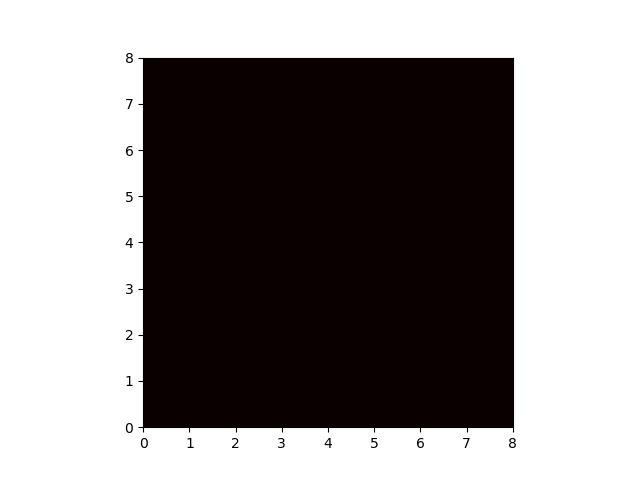

In [13]:
potentialAnimation = animateImages(
        length, 
        simulator.potentials, 
        10, 
        0, 
        potentialHeight, 
        colorMap = "hot"
    )

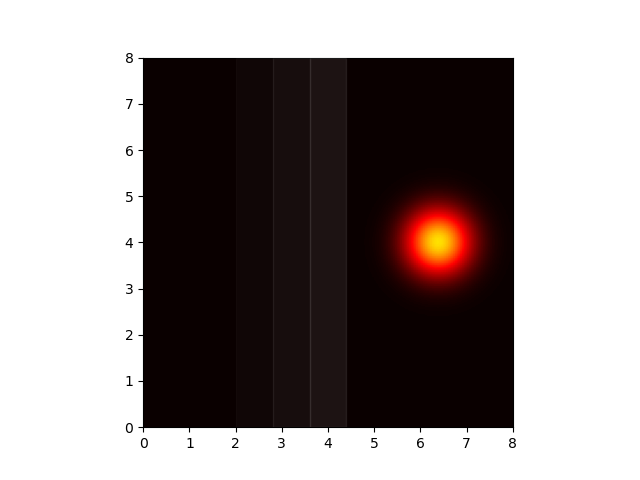

In [14]:
waveAnimation = animateImages(
        length, 
        simulator.probabilities, 
        10, 
        0, 
        math.max(simulator.probabilities), 
        constantStairwellLengthRatios, 
        constantStairwellPotentialRatios, 
        colorMap = "hot"
    )

In [15]:
postBarrierProbabilities, postBarrierCutFrames = totalProbabilityInRegion(
        probabilities, 
        pointCount, 
        spatialStep, 
        0, 
        0, 
        barrierStart, 
        1
    )

In [16]:
preBarrierProbabilities, preBarrierCutFrames = totalProbabilityInRegion(
        probabilities, 
        pointCount, 
        spatialStep, 
        barrierStart + barrierWidth, 
        0, 
        1 - (barrierStart + barrierWidth), 
        1
    )

In [17]:
intraBarrierProbabilities, intraBarrierCutFrames = totalProbabilityInRegion(
        probabilities, 
        pointCount, 
        spatialStep, 
        barrierStart, 
        0, 
        barrierWidth, 
        1
    )

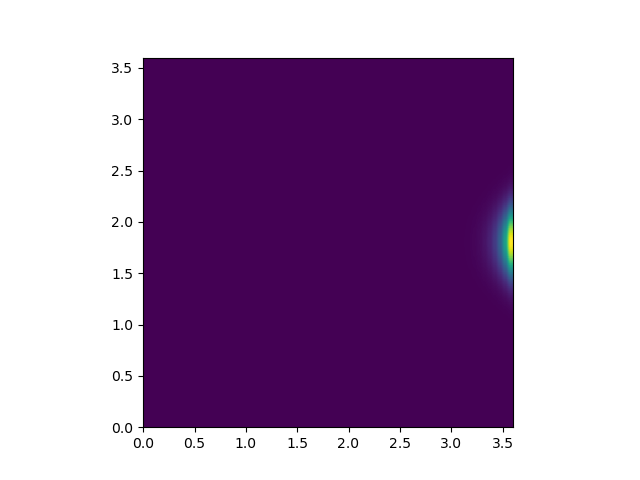

In [18]:
cutAnimationPostBarrier = animateImages(length * barrierStart, postBarrierCutFrames, interval = 50)

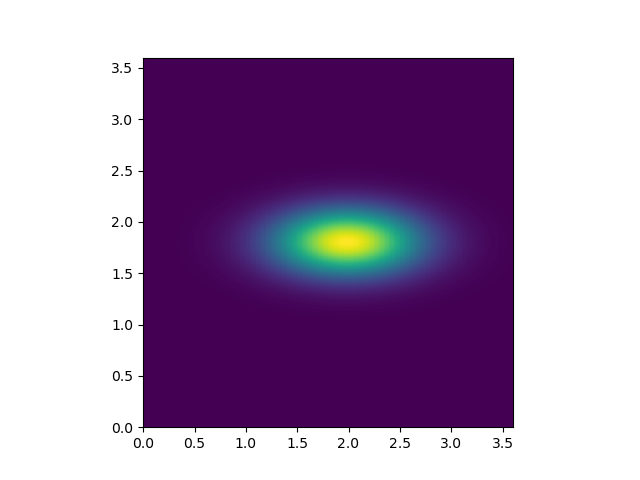

In [19]:
cutAnimationPreBarrier = animateImages(length * (1 - (barrierStart + barrierWidth)), preBarrierCutFrames, interval = 50)

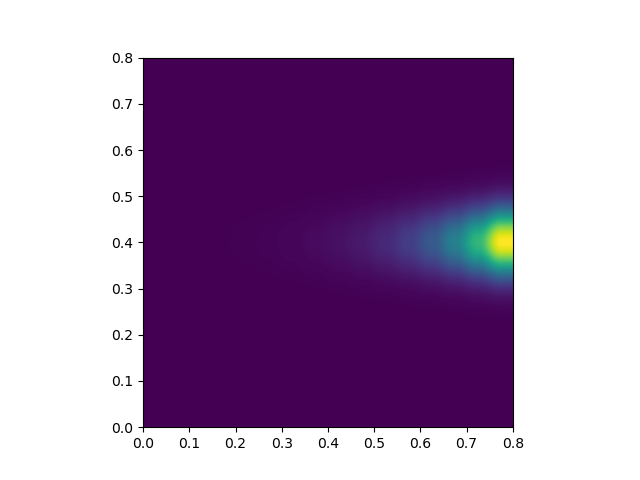

In [20]:
cutAnimationIntraBarrier = animateImages(length * barrierWidth, intraBarrierCutFrames, interval = 50)

Text(0.5, 1.0, 'Total Probability in Different Regions')

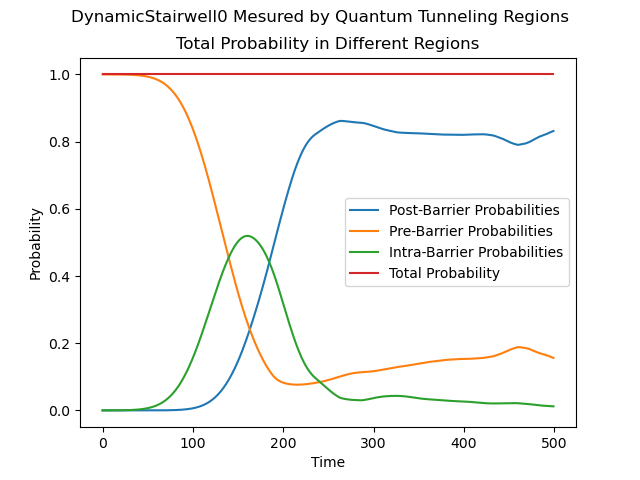

In [21]:
plt.figure()
time = np.arange(len(postBarrierProbabilities))
plt.plot(time, postBarrierProbabilities)
plt.plot(time, preBarrierProbabilities)
plt.plot(time, intraBarrierProbabilities)
plt.plot(time, postBarrierProbabilities + intraBarrierProbabilities + preBarrierProbabilities)
plt.legend([
        "Post-Barrier Probabilities", 
        "Pre-Barrier Probabilities", 
        "Intra-Barrier Probabilities", 
        "Total Probability"
    ])
plt.xlabel("Time")
plt.ylabel("Probability")
plt.suptitle(caseName + " Mesured by Quantum Tunneling Regions")
plt.title("Total Probability in Different Regions")

In [22]:
import pandas as pd

In [23]:
frame = pd.DataFrame({
        "Post-Barrier-Probabilities" : postBarrierProbabilities, 
        "Pre-Barrier-Probabilities" : preBarrierProbabilities, 
        "Intra-Barrier-Probabilities" : intraBarrierProbabilities, 
        "Total-Probability" :  postBarrierProbabilities + intraBarrierProbabilities + preBarrierProbabilities, 
        "Time" : time, 
        "spatialStep" : spatialStep, 
        "temporalStep" : temporalStep, 
        "courantNumber" : courantNumber, 
        "pointCount" : pointCount, 
        "barrierStart" : barrierStart, 
        "barrierWidth" : barrierWidth, 
        "potentialHeight" : potentialHeight, 
        "packetStartX" : packetStartX, 
        "packetStartY" : packetStartY, 
        "packetStandardDeviation" : packetStandardDeviation, 
        "packetWaveNumber" : packetWaveNumber, 
        "constantStairwellLengthRatios" : str(constantStairwellLengthRatios), 
        "constantStairwellPotentialRatios" : str(constantStairwellPotentialRatios), 
        "length" : length, 
        "backend" : backend, 
    })

In [24]:
frame.to_csv(caseName + ".csv")

In [25]:
waveAnimation.save(caseName + ".mp4")

In [26]:
potentialAnimation.save(caseName + "Potential.mp4")

In [27]:
unknownStepMatrix = simulator.createNextStepMatrix(simulator.potentials[-1])

In [28]:
unknownStepMatrix.todense()

matrix([[1.-0.5j  , 0.+0.125j, 0.+0.j   , ..., 0.+0.j   , 0.+0.j   ,
         0.+0.j   ],
        [0.+0.125j, 1.-0.5j  , 0.+0.125j, ..., 0.+0.j   , 0.+0.j   ,
         0.+0.j   ],
        [0.+0.j   , 0.+0.125j, 1.-0.5j  , ..., 0.+0.j   , 0.+0.j   ,
         0.+0.j   ],
        ...,
        [0.+0.j   , 0.+0.j   , 0.+0.j   , ..., 1.-0.5j  , 0.+0.125j,
         0.+0.j   ],
        [0.+0.j   , 0.+0.j   , 0.+0.j   , ..., 0.+0.125j, 1.-0.5j  ,
         0.+0.125j],
        [0.+0.j   , 0.+0.j   , 0.+0.j   , ..., 0.+0.j   , 0.+0.125j,
         1.-0.5j  ]])

In [29]:
knownStepMatrix = simulator.createCurrentStepMatrix(simulator.potentials[-1])

In [30]:
knownStepMatrix.todense()

matrix([[1.+0.5j  , 0.-0.125j, 0.+0.j   , ..., 0.+0.j   , 0.+0.j   ,
         0.+0.j   ],
        [0.-0.125j, 1.+0.5j  , 0.-0.125j, ..., 0.+0.j   , 0.+0.j   ,
         0.+0.j   ],
        [0.+0.j   , 0.-0.125j, 1.+0.5j  , ..., 0.+0.j   , 0.+0.j   ,
         0.+0.j   ],
        ...,
        [0.+0.j   , 0.+0.j   , 0.+0.j   , ..., 1.+0.5j  , 0.-0.125j,
         0.+0.j   ],
        [0.+0.j   , 0.+0.j   , 0.+0.j   , ..., 0.-0.125j, 1.+0.5j  ,
         0.-0.125j],
        [0.+0.j   , 0.+0.j   , 0.+0.j   , ..., 0.+0.j   , 0.-0.125j,
         1.+0.5j  ]])